In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score,explained_variance_score

from math import sqrt
from sklearn.feature_selection import RFE
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import env
import wrangle
import viz
import split_scale
import zillow_modeling

# Step 1. Wrangle the data

- The get_df function returns a clean dataframe by performing the following tasks:
> 1. A SQL query of the Zillow database produces results that include only single family homes purchased between May and June 2017. 
> 2. Zeros and null values were filtered out and removed. 
> 3. Any non essential columns were dropped
> 4. A new column was added designating the county where each home is located. All homes in the data set are located in the state of California
> 5. A calculated field 'tax_rate' was also added


In [2]:
df = wrangle.get_df()
df

,square_feet,taxes,home_value,bedroom_count,bathroom_count,County,tax_rate
0,1458.0,2319.90,136104.0,3.0,2.0,Los Angeles,0.017045
1,1421.0,543.69,35606.0,2.0,1.0,Los Angeles,0.015270
2,2541.0,9819.72,880456.0,4.0,3.0,Orange,0.011153
3,1650.0,7673.19,614000.0,3.0,2.0,Los Angeles,0.012497
4,693.0,3267.47,274237.0,2.0,1.0,Los Angeles,0.011915
...,...,...,...,...,...,...,...
14985,2526.0,5718.72,458903.0,5.0,3.0,Orange,0.012462
14986,2735.0,1465.88,115387.0,5.0,3.0,Orange,0.012704
14987,1536.0,3519.78,297097.0,3.0,2.0,Los Angeles,0.011847
14988,2655.0,8065.50,746963.0,5.0,3.0,Orange,0.010798


- To double check that there are no zeros or null values before we start working with the data, run the following asserts and NA count

In [3]:
assert (df['square_feet'] == 0).sum() < 1 , "There are zeros in this column. Handle them before proceeding"
assert (df['taxes'] == 0).sum() < 1 , "There are zeros in this column. Handle them before proceeding"
assert (df['home_value'] == 0).sum() < 1 , "There are zeros in this column. Handle them before proceeding"
assert (df['bedroom_count'] == 0).sum() < 1 , "There are zeros in this column. Handle them before proceeding"
assert (df['bathroom_count'] == 0).sum() < 1 , "There are zeros in this column. Handle them before proceeding"

In [4]:
df.isnull().sum()

square_feet       0
taxes             0
home_value        0
bedroom_count     0
bathroom_count    0
County            0
tax_rate          0
dtype: int64

- Brief overview of the shape of the data and data types

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14989 entries, 0 to 14989
Data columns (total 7 columns):
square_feet       14989 non-null float64
taxes             14989 non-null float64
home_value        14989 non-null float64
bedroom_count     14989 non-null float64
bathroom_count    14989 non-null float64
County            14989 non-null object
tax_rate          14989 non-null float64
dtypes: float64(6), object(1)
memory usage: 936.8+ KB


# Step 2: Explore what we have

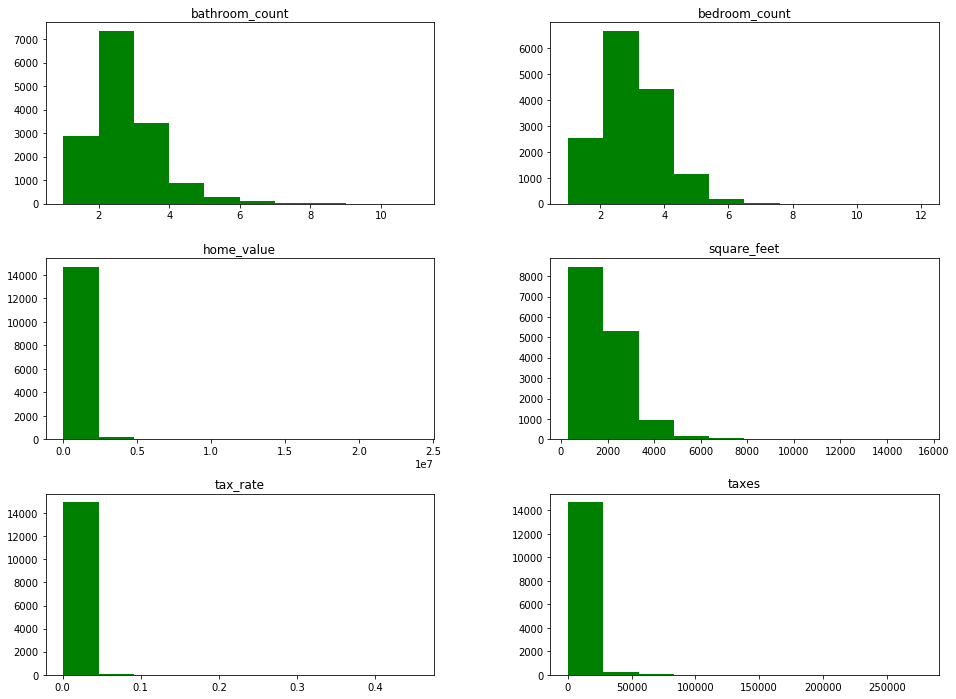

In [6]:
df.hist(grid=False, figsize=(16,12), color='green')
plt.show()

In [7]:
df.corr(method ='pearson') 

,square_feet,taxes,home_value,bedroom_count,bathroom_count,tax_rate
square_feet,1.000000,0.603672,0.602110,0.634737,0.855666,-0.095110
taxes,0.603672,1.000000,0.989347,0.279657,0.519436,-0.063567
home_value,0.602110,0.989347,1.000000,0.276025,0.517097,-0.134599
bedroom_count,0.634737,0.279657,0.276025,1.000000,0.643954,-0.056054
bathroom_count,0.855666,0.519436,0.517097,0.643954,1.000000,-0.097136
tax_rate,-0.095110,-0.063567,-0.134599,-0.056054,-0.097136,1.000000


- The Pearson's R test is used to compare two continuous variables and see if they are linearly correlated, and the strength of the correlation.
- Right off the bat I see some fairly stong correlations between our target variable (home_value) and square_feet as well as bathroom_count. 
- In addition, bath and bed count are highly correlated. I will look at the p value of that correlation to determine the probablity of that correlation due to chance
- I also note that there is some correlation between our independent variable. I will consider running an RFE later to determine weight of this correlation when selecting the proper variables for modeling

In [8]:
alpha = 0.05
test_results = stats.pearsonr(df.bedroom_count, df.bathroom_count)
r, p = test_results
print(f'p is {p:.10f}')
print(f'Is the p value less than alpha? {p < alpha}')

p is 0.0000000000
Is the p value less than alpha? True


The chances that bedroom and bathroom count are *__that__* correlated due to chance are very slim.

### Hypothesis

- $H_0$: Bedroom count bathroom count and square footage have no effect on the value of a single-family home
- $H_a$: Bedroom count bathroom count and square footage have an effect on the value of a single-family home
- alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

Run a 2 tailed t test on bedrooom and bathroom count. To do this:
> 1. First separate bedroom and bathroom counts into greater than and less than 3 to make categorical variables
> 2. Then run a 2 tailed t test with the continuous variable of home_value to compare the strength of the relationship


In [9]:
# We'll start with bedrooms
alpha = 0.05
greater_than_three = df[df['bedroom_count'] > 3]
three_or_less = df[df['bedroom_count'] <= 3]
test_results = stats.ttest_ind(greater_than_three.home_value, three_or_less.home_value)
test_statistic, p_value = test_results
print(f'p value is {p_value:.10f}') 
print(f'Is the p value less than alpha? {p_value < alpha}')

p value is 0.0000000000
Is the p value less than alpha? True


In [10]:
# Now bathrooms
alpha = 0.05
greater_than_three = df[df['bathroom_count'] > 3]
three_or_less = df[df['bathroom_count'] <= 3]
test_results = stats.ttest_ind(greater_than_three.home_value, three_or_less.home_value)
test_statistic, p_value = test_results
print(f'p value is {p_value:.10f}')
print(f'Is the p value less than alpha? {p_value < alpha}')

p value is 0.0000000000
Is the p value less than alpha? True


In [11]:
# We will also explore the strength of the relationship between 
# square footage and the home value
alpha = 0.05
test_results = stats.pearsonr(df.square_feet, df.home_value)
r, p = test_results
print(f'p is {p:.10f}')
print(f'r is {r: .10f}, fairly strong correlation')
print(f'Is the p value less than alpha? {p < alpha}')

p is 0.0000000000
r is  0.6021103241, fairly strong correlation
Is the p value less than alpha? True


##### Based on the Pearson's R and t-test results, both with p_values < $\alpha$, I reject the null hypothesis ($H_0$: Bedroom count bathroom count and square footage have no effect on the value of a single-family home).

### Let's answer the question about distribution of tax rates by county

In [12]:
df.County.value_counts()

Los Angeles    9604
Orange         4094
Ventura        1291
Name: County, dtype: int64

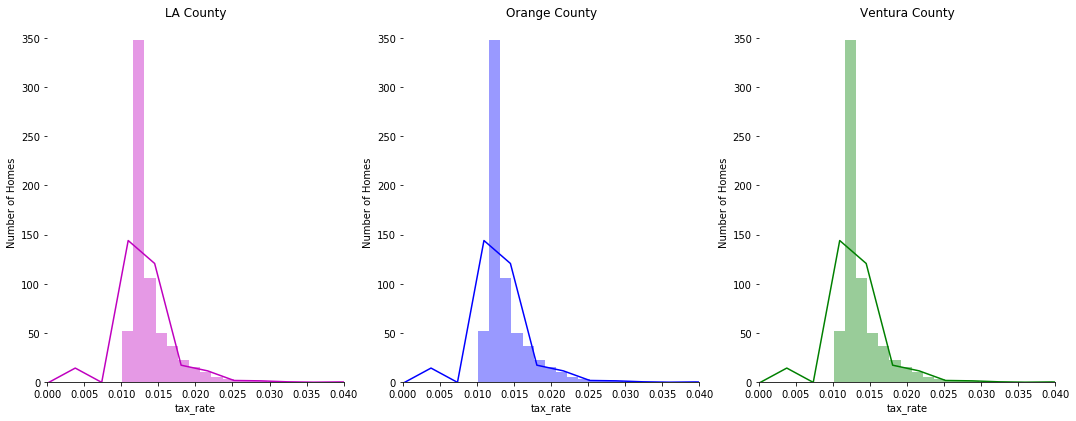

In [13]:
#Distributions of tax_rates by county
plot = viz.plot_distributions()

In [14]:
county_mean_tax_rate = pd.DataFrame(round(df.groupby("County").tax_rate.mean(),4))
county_mean_tax_rate.columns = ['Mean Tax Rate']

In [15]:
county_mean_tax_rate

,Mean Tax Rate
County,
Los Angeles,0.0142
Orange,0.0121
Ventura,0.0121


# Step 3: Modeling

### Start with splitting the data

- Our target variable is the home_value
- We were told to use bedroom and bathroom count along with square root. I'll run an RFE to determine if those three are the best features to use given that they showed some correlation with eachother

In [16]:
train, test = split_scale.split_data(df)

- Now that the data is split into the train and test variables, let's take a look at each variable

In [17]:
train.head()

,square_feet,taxes,home_value,bedroom_count,bathroom_count,County,tax_rate
1860,1938.0,10310.56,208558.0,4.0,2.0,Los Angeles,0.049437
442,2891.0,9189.99,757831.0,4.0,4.0,Los Angeles,0.012127
14935,1574.0,5143.48,446004.0,3.0,2.5,Orange,0.011532
5221,2304.0,7069.39,613428.0,4.0,3.0,Los Angeles,0.011524
3663,998.0,830.35,44679.0,2.0,1.0,Los Angeles,0.018585


In [18]:
train.shape

(11241, 7)

In [19]:
test.head()

,square_feet,taxes,home_value,bedroom_count,bathroom_count,County,tax_rate
3144,2774.0,4309.47,286000.0,4.0,3.0,Los Angeles,0.015068
6315,2142.0,8822.75,750000.0,4.0,3.0,Los Angeles,0.011764
2442,2150.0,4161.99,279000.0,3.0,2.0,Los Angeles,0.014918
4483,3359.0,6895.67,559002.0,4.0,4.0,Los Angeles,0.012336
9536,2743.0,12796.32,1177495.0,4.0,3.5,Orange,0.010867


In [20]:
test.shape

(3748, 7)

- Split looks good!

#### Now that the data is split apporpriately, let's define our target and dependent variables for both the train and test data

In [21]:
X_train = train[['square_feet', 'bedroom_count', 'bathroom_count']]
X_test = test[['square_feet', 'bedroom_count', 'bathroom_count']]
y_train = train[['home_value']]
y_test = test[['home_value']]

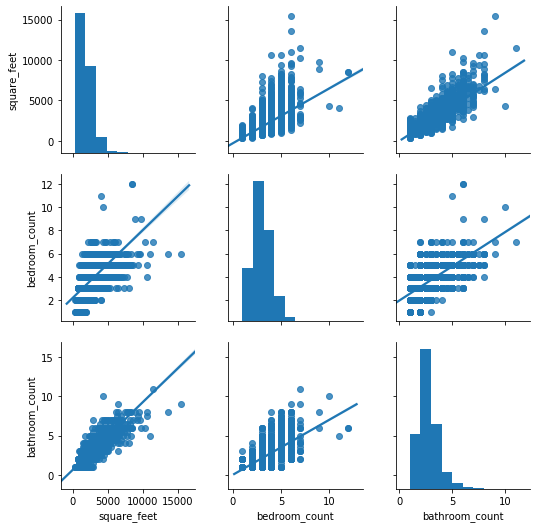

In [22]:
sns.pairplot(X_train, kind="reg")
plt.show()

- Next step is to create a dataframe that will hold the actual home values as well as all the predictions from the models we will be creating. 
> I'll make a copy of the data so as not to mutate the original dataset

In [23]:
model_df = y_train.copy()
model_df.head()

,home_value
1860,208558.0
442,757831.0
14935,446004.0
5221,613428.0
3663,44679.0


In [24]:
model_df = model_df.rename(columns={'home_value':'actual'})
model_df.head()

,actual
1860,208558.0
442,757831.0
14935,446004.0
5221,613428.0
3663,44679.0


- I'll start by creating a basline model. In order for our model to be worth working with, the predictions given will need to be better than making predictions using just the mean price of homes

In [25]:
model_df['yhat_bl'] = model_df['actual'].mean()
model_df.head()

,actual,yhat_bl
1860,208558.0,543719.613202
442,757831.0,543719.613202
14935,446004.0,543719.613202
5221,613428.0,543719.613202
3663,44679.0,543719.613202


- Let's do a linear model
> Right now, the only numeric features we can work with are the bedroom count, bathroom count and square footage. Using the tax amount would be using a feature based on the target feature which would produce unfairly accurate data.

In [26]:
linear_model=LinearRegression()
linear_model.fit(X_train,y_train)
linear_predictions=linear_model.predict(X_train)
model_df["linear_predictions"]=linear_predictions

In [27]:
model_df

,actual,yhat_bl,linear_predictions
1860,208558.0,543719.613202,4.112534e+05
442,757831.0,543719.613202,9.964268e+05
14935,446004.0,543719.613202,4.330799e+05
5221,613428.0,543719.613202,6.525366e+05
3663,44679.0,543719.613202,2.137686e+05
...,...,...,...
5219,535719.0,543719.613202,4.652660e+05
12253,231304.0,543719.613202,1.406528e+05
1346,1116000.0,543719.613202,1.443775e+06
11647,353000.0,543719.613202,2.824829e+05


- For plotting purposes, I'll add the residuals for both the baseline and the linear model to this dataframe

In [28]:
model_df['residual_bl'] = model_df['yhat_bl'] - model_df['actual']
model_df

,actual,yhat_bl,linear_predictions,residual_bl
1860,208558.0,543719.613202,4.112534e+05,335161.613202
442,757831.0,543719.613202,9.964268e+05,-214111.386798
14935,446004.0,543719.613202,4.330799e+05,97715.613202
5221,613428.0,543719.613202,6.525366e+05,-69708.386798
3663,44679.0,543719.613202,2.137686e+05,499040.613202
...,...,...,...,...
5219,535719.0,543719.613202,4.652660e+05,8000.613202
12253,231304.0,543719.613202,1.406528e+05,312415.613202
1346,1116000.0,543719.613202,1.443775e+06,-572280.386798
11647,353000.0,543719.613202,2.824829e+05,190719.613202


In [29]:
model_df['residual_lm'] = model_df['linear_predictions'] - model_df['actual']
model_df

,actual,yhat_bl,linear_predictions,residual_bl,residual_lm
1860,208558.0,543719.613202,4.112534e+05,335161.613202,202695.442740
442,757831.0,543719.613202,9.964268e+05,-214111.386798,238595.757168
14935,446004.0,543719.613202,4.330799e+05,97715.613202,-12924.069121
5221,613428.0,543719.613202,6.525366e+05,-69708.386798,39108.557265
3663,44679.0,543719.613202,2.137686e+05,499040.613202,169089.626152
...,...,...,...,...,...
5219,535719.0,543719.613202,4.652660e+05,8000.613202,-70452.979330
12253,231304.0,543719.613202,1.406528e+05,312415.613202,-90651.244437
1346,1116000.0,543719.613202,1.443775e+06,-572280.386798,327774.880737
11647,353000.0,543719.613202,2.824829e+05,190719.613202,-70517.126626


# Step 4: Evaluation

In [30]:
mse_linear = mse(model_df.actual, model_df.linear_predictions)
mse_bl = mse(model_df.actual, model_df.yhat_bl)

In [31]:
RMSE = sqrt(mse_linear)
RMSE_bl = sqrt(mse_bl)
(RMSE, RMSE_bl)

(574158.3351089557, 731765.1378079755)

- Those are big numbers, let's make this simple:

In [49]:
print(f'Is the RMSE of the linear model less than the RMSE of the baseline model? {RMSE < RMSE_bl}')

Is the RMSE of the linear model less than the RMSE of the baseline model? True


Text(0.5, 1.0, 'Linear Model Residuals')

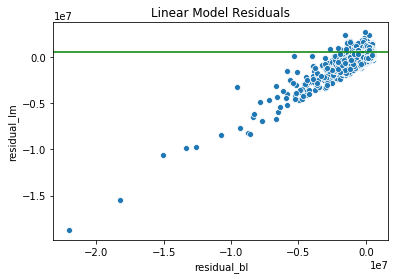

In [48]:
graph = sns.scatterplot(model_df.residual_bl, model_df.residual_lm,)
graph.axhline(543719.6132017651, color = 'green')
plt.title('Linear Model Residuals')

In [51]:
model_df.head()

,actual,yhat_bl,linear_predictions,residual_bl,residual_lm
1860,208558.0,543719.613202,411253.442740,335161.613202,202695.442740
442,757831.0,543719.613202,996426.757168,-214111.386798,238595.757168
14935,446004.0,543719.613202,433079.930879,97715.613202,-12924.069121
5221,613428.0,543719.613202,652536.557265,-69708.386798,39108.557265
3663,44679.0,543719.613202,213768.626152,499040.613202,169089.626152


In [57]:
evs = explained_variance_score(model_df.actual, model_df.linear_predictions)
print(f'Explained Variance = {round(evs,3)*100}%', )

Explained Variance = 38.4%


- The linear model is an improvement! 
- Approximately 38.4% of the variation in predictions can be attributed to these features
- There appears to be a fairly distinct pattern in the data suggesting that there are some drivers not accounted for
- Let's apply the linear model to the test data

In [36]:
one = model_df.residual_lm.mean()

In [37]:
two = model_df.residual_bl.mean()

In [38]:
one < two

True

In [39]:
test.shape

(3748, 7)

In [40]:
testdf = y_test.copy()
testdf.head()

,home_value
3144,286000.0
6315,750000.0
2442,279000.0
4483,559002.0
9536,1177495.0


In [41]:
testdf = testdf.rename(columns={'home_value':'actual'})
testdf.head()

,actual
3144,286000.0
6315,750000.0
2442,279000.0
4483,559002.0
9536,1177495.0


In [42]:
testdf['yhat_bl'] = testdf['actual'].mean()
testdf.head()

,actual,yhat_bl
3144,286000.0,535671.444237
6315,750000.0,535671.444237
2442,279000.0,535671.444237
4483,559002.0,535671.444237
9536,1177495.0,535671.444237


In [43]:
linear_model=LinearRegression()
linear_model.fit(X_test,y_test)
linear_predictions=linear_model.predict(X_test)
testdf["linear_predictions"]=linear_predictions

In [44]:
testdf

,actual,yhat_bl,linear_predictions
3144,286000.0,535671.444237,8.928387e+05
6315,750000.0,535671.444237,5.587883e+05
2442,279000.0,535671.444237,6.869413e+05
4483,559002.0,535671.444237,1.211391e+06
9536,1177495.0,535671.444237,8.811253e+05
...,...,...,...
11625,271949.0,535671.444237,9.483376e+05
1275,119393.0,535671.444237,4.385177e+05
5753,497915.0,535671.444237,9.547515e+05
10039,321393.0,535671.444237,5.140308e+05


In [45]:
mse_linear = mse(testdf.actual, testdf.linear_predictions)
mse_bl = mse(testdf.actual, testdf.yhat_bl)

In [46]:
RMSE = sqrt(mse_linear)
RMSE_bl = sqrt(mse_bl)
(RMSE, RMSE_bl)

(573137.2960747385, 728415.0120288163)

In [47]:
RMSE < RMSE_bl

True

# Step 5: Conclusions and Recomendations 

- The linear regression model based on the variables square footage, bedroom count, and bathroom count, produced better predictions than the baseline model.
- The null hypothesis (**$H_0$: Bedroom count bathroom count and square footage have no effect on the value of a single-family home**) is rejected.
- Based on the correlations between the independent variables, I recommend including a degree of feature engineering, and inclusion of more features in the initial dataset to create more fields that better predict the value of a home.